## Modelo Macroscopico

C:\Users\crist\AppData\Local\Temp\ipykernel_2336\3607093559.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


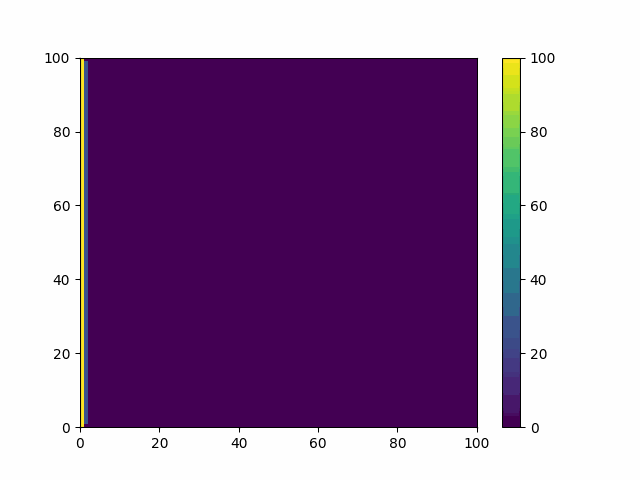

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Parámetros del dominio
nx, ny = 100, 100
dx, dy = 1.0, 1.0
k = 1.0  # Permeabilidad

# Presión inicial
P = np.zeros((ny, nx))

# Condiciones de contorno (ejemplo: gradiente de presión en el borde izquierdo)
P[:, 0] = 100

# Función de simulación usando la ley de Darcy (diferencias finitas)
def simulate_darcy(P, k, dx, dy, nt):
    images = []
    for t in range(nt):
        Pn = P.copy()
        P[1:-1, 1:-1] = ((Pn[1:-1, 2:] + Pn[1:-1, 0:-2]) * dy**2 + (Pn[2:, 1:-1] + Pn[0:-2, 1:-1]) * dx**2) / (2.0 * (dx**2 + dy**2))
        
        # Visualizar y guardar la imagen
        fig, ax = plt.subplots()
        c = ax.pcolormesh(P, cmap='viridis')
        fig.colorbar(c, ax=ax)
        filename = f"./E2_images/temp_step_{t}.png"
        plt.savefig(filename)
        plt.close()
        images.append(imageio.imread(filename))

    return images

images = simulate_darcy(P, k, dx, dy, nt=50)

# Convertir imágenes en GIF
imageio.mimsave('darcy_simulation.gif', images, duration=0.5, loop=0)

from IPython.display import display, Image

display(Image(filename="darcy_simulation.gif"))



## Modelo Microscopico

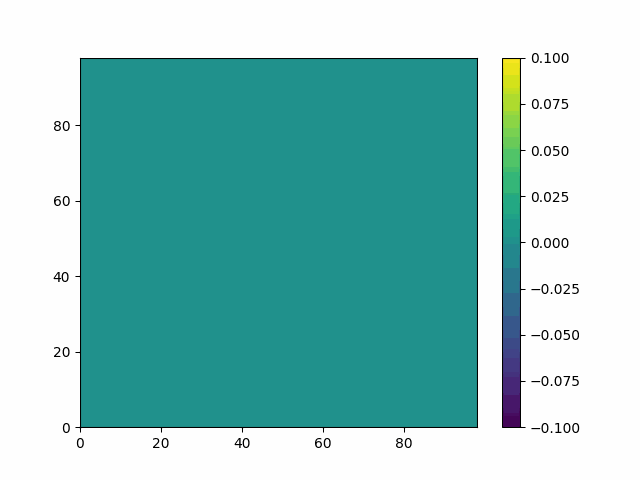

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Parámetros del dominio
nx, ny = 100, 100
dx, dy = 1.0, 1.0

# Parámetros físicos
rho = 1.0  # Densidad
nu = 0.1  # Viscosidad

# Velocidades y presiones
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
u_prev = np.zeros((ny, nx))
v_prev = np.zeros((ny, nx))
b = np.zeros((ny, nx))

dt = 0.01  # Paso temporal

def build_up_b(b, rho, dt, u, v, dx, dy):
    b[1:-1, 1:-1] = (rho * (1/dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) - ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 - 2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) * (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx)) - ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    return b

def navier_stokes(u, v, p, rho, nu, dx, dy, dt, nt):
    u_prev = u.copy()
    v_prev = v.copy()
    b = np.zeros((ny, nx))  # Inicialización de b dentro de la función
    
    images = []
    for n in range(nt):
        u_prev = u.copy()
        v_prev = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        
        # Ecuación de presión (Poisson)
        for q in range(25):
            p_prev = p.copy()
            p[1:-1, 1:-1] = (((p_prev[1:-1, 2:] + p_prev[1:-1, 0:-2]) * dy**2 + (p_prev[2:, 1:-1] + p_prev[0:-2, 1:-1]) * dx**2) / (2 * (dx**2 + dy**2)) - dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 1:-1])
        
        # Ecuaciones de momentum
        u[1:-1, 1:-1] = (u_prev[1:-1, 1:-1] - u_prev[1:-1, 1:-1] * dt / dx * (u_prev[1:-1, 1:-1] - u_prev[1:-1, 0:-2]) - v_prev[1:-1, 1:-1] * dt / dy * (u_prev[1:-1, 1:-1] - u_prev[0:-2, 1:-1]) - dt / (2 * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) + nu * (dt / dx**2 * (u_prev[1:-1, 2:] - 2 * u_prev[1:-1, 1:-1] + u_prev[1:-1, 0:-2]) + dt / dy**2 * (u_prev[2:, 1:-1] - 2 * u_prev[1:-1, 1:-1] + u_prev[0:-2, 1:-1])))
        v[1:-1, 1:-1] = (v_prev[1:-1, 1:-1] - u_prev[1:-1, 1:-1] * dt / dx * (v_prev[1:-1, 1:-1] - v_prev[1:-1, 0:-2]) - v_prev[1:-1, 1:-1] * dt / dy * (v_prev[1:-1, 1:-1] - v_prev[0:-2, 1:-1]) - dt / (2 * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) + nu * (dt / dx**2 * (v_prev[1:-1, 2:] - 2 * v_prev[1:-1, 1:-1] + v_prev[1:-1, 0:-2]) + dt / dy**2 * (v_prev[2:, 1:-1] - 2 * v_prev[1:-1, 1:-1] + v_prev[0:-2, 1:-1])))

        # Condiciones de frontera
        u[0, :] = 0
        u[:, 0] = 0
        u[:, 0] = 1  # Inyectamos velocidad en el borde derecho
        u[-1, :] = 0
        v[0, :] = 0
        v[-1, :] = 0
        v[:, 0] = 0
        v[:, -1] = 0
        
        # Visualizar y guardar la imagen
        fig, ax = plt.subplots()
        magnitude = np.sqrt(u[1:-1, 1:-1]**2 + v[1:-1, 1:-1]**2)
        c = ax.pcolormesh(magnitude, cmap='viridis')
        fig.colorbar(c, ax=ax)
        filename = f"./E2_images/temp_step_ns_{n}.png"
        plt.savefig(filename)
        plt.close()
        images.append(imageio.imread(filename))

    return images

images_ns = navier_stokes(u, v, p, rho, nu, dx, dy, dt, nt=50)

# Convertir imágenes en GIF
imageio.mimsave('navier_stokes_simulation.gif', images_ns, duration=0.5, loop=0)

from IPython.display import display, Image

display(Image(filename="navier_stokes_simulation.gif"))

## Modelo Combinado

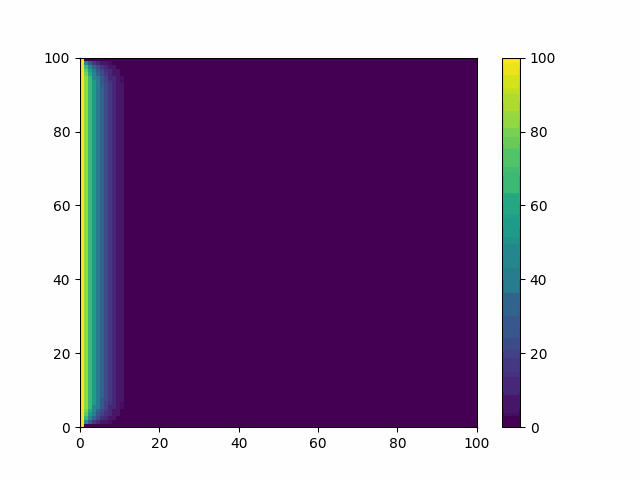

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Parámetros generales
nx, ny = 100, 100
nt = 50
rho = 1
nu = 0.1
dt = 0.001
k = 1.0  # Permeabilidad

P = np.zeros((ny, nx))
P[:, 0] = 100  # Condición de contorno inicial para presión

# Función para resolver la ecuación de presión (Poisson)
def pressure_poisson(p, dx, dy):
    pn = np.empty_like(p)
    pn = p.copy()
    for q in range(nt):
        pn = p.copy()
        p[1:-1, 1:-1] = ((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                        (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) / (2 * (dx**2 + dy**2))
    return p

# Simulación combinada
def combined_simulation(nt, P, dx, dy, k):
    images = []
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    
    for n in range(nt):
        P = pressure_poisson(P, dx, dy)  # Actualiza presión basada en Darcy
        un = u.copy()
        vn = v.copy()
        
        # Actualización basada en Navier-Stokes
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] - un[1:-1, 1:-1] * dt / dx * 
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) - vn[1:-1, 1:-1] * dt / dy * 
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) - dt / (2 * rho * dx) * 
                        (P[1:-1, 2:] - P[1:-1, 0:-2]) + nu * (dt / dx**2 * 
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) + dt / dy**2 * 
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
        
        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] - un[1:-1, 1:-1] * dt / dx * 
                        (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) - vn[1:-1, 1:-1] * dt / dy * 
                        (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) - dt / (2 * rho * dy) * 
                        (P[2:, 1:-1] - P[0:-2, 1:-1]) + nu * (dt / dx**2 * 
                        (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) + dt / dy**2 *
                        (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        # Visualización
        fig, ax = plt.subplots()
        c = ax.pcolormesh(P, cmap='viridis')
        fig.colorbar(c, ax=ax)
        filename = f"./E2_images/temp_combined_{n}.png"
        plt.savefig(filename)
        plt.close()
        images.append(imageio.imread(filename))
        
    return images

# Generar las imágenes
images = combined_simulation(nt, P, dx, dy, k)
# Guardar las imágenes como GIF
imageio.mimsave('combined_simulation.gif', images, duration=0.5, loop=0)


from IPython.display import display, Image

display(Image(filename="combined_simulation.gif"))


### a. Diferencia entre enfoque multiescala concurrente y enfoque multiescala secuencial

El enfoque **multiescala concurrente** implica que se realizan simulaciones tanto a nivel macroscópico como microscópico simultáneamente, y ambos modelos intercambian información e influyen entre sí durante la simulación. Por otro lado, el enfoque **multiescala secuencial** generalmente implica que se realiza primero una simulación a nivel macroscópico, y luego su resultado informa una simulación microscópica (o viceversa), pero no hay un intercambio continuo de información entre las dos escalas durante la simulación.

### b. Información pasada del modelo macroscópico al microscópico

En las simulaciones que realizamos, el modelo macroscópico basado en la Ley de Darcy nos proporciona una distribución de presiones a lo largo del dominio. Esta distribución de presión se utiliza como condición inicial o de contorno en el modelo microscópico basado en las ecuaciones de Navier-Stokes. La presión afecta directamente la velocidad y el comportamiento del fluido en el nivel microscópico. Por lo tanto, cualquier cambio en el modelo macroscópico afectará directamente cómo se comporta el fluido a nivel microscópico.

### c. Ventajas de utilizar modelado multiescala concurrente

1. **Mayor Precisión**: Al tener en cuenta las interacciones entre las escalas, el modelo puede capturar efectos que un modelo de una sola escala podría pasar por alto.
2. **Flexibilidad**: Se pueden realizar cambios en una escala y observar cómo afectan la otra, esto es útil para escenarios donde los cambios en el entorno a nivel macro pueden tener efectos importantes a nivel micro.
3. **Captura de Fenómenos Complejos**: Algunos fenómenos, especialmente en la mecánica de fluidos y en los medios porosos, no pueden ser completamente descritos solo a nivel macroscópico o microscópico entonces un enfoque multiescala permite una descripción más completa.
4. **Optimización Computacional**: En algunos casos, puede ser computacionalmente más eficiente simular ciertos fenómenos a una escala específica, ya que al utilizar un enfoque multiescala, podemos aprovechar la eficiencia de cada escala para diferentes partes del problema.
